In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as cons
import astropy.coordinates as coord
from astropy.coordinates import Galactocentric
from astropy.coordinates import SkyCoord

import pandas as pd
from astroquery.utils.tap.core import TapPlus


from scipy import stats
from scipy import odr

# Estimation of Oxygen abundance using temperature-metallicity relationships estimated from optical data

## Description of the Problem:

### We're going to see how is the behavior using the tempeture-metallicity relatioship by Shaver et al 1983, our tempeture-metallicity relationship without tempeture fluctions  $t^2 = 0$ and with tempeture fluctions $t^2 > 0$

### Shaver et al. (1983):

- H II region electron temperatures are a proxy for their nebular metallicities (e.g., Churchwell & Walmsley 1975). The H II region electron temperature structure across the Galactic disk thus reveals structure in metallicity. Shaver et al. (1983) derived an empirical relationship between H II region metallicities, determined using optical collisionally excited lines to derive the oxygen and hydrogen column densities, and electron temperatures, determined from RRLs:

$$ 12 + \log_{10}(O/H) = (9.82 \pm 0.02) - (1.49 \pm 0.11) \dfrac{T_e}{10^4K} $$


### Our Temperature-metallicity relationship without temperature fluctions $t^2 = 0$: 

- In this case we'll apply our relationship we found using our HII and SFG regions when $t^2 = 0$ to estimate the oxygen abundance from electron temperature. The equation is:

$$ 12 + \log_{10}(O/H) = (9.29 \pm 0.01) - (0.96 \pm 0.01) \dfrac{Te}{10^4K} $$

- Primero: aplicaremos nuestro Ajuste Cuadratico ODR con fluctuaciones de temperatura $t^2 > 0$ y propagaremos errores utilizando la metodologia tradicional de propagación de errores.

- Segundo: aplicaremos nuestro Ajuste Lineal ODR con fluctuaciones de temperatura $t^2 > 0$ y propagaremos errores utilizando la metodologia tradicional de propagación de errores.


### Ours Temperautre-metallicity relationships with temperature fluctions $t^2 > 0$:

- In this case we'll apply our relationship we found using our HII and SFG regions when $t^2 > 0$ to estimate the oxygen abundance from electron temperature. In this case we have two differents cases:

    -First: Our Lineal adjustment ODR with temperature fluctions $t^2  >0$ and traditional error propagation. The equation for this case is:
    
    $$ 12 + \log_{10}(O/H) = (9.63 \pm 0.05) - (1.15 \pm 0.06) \dfrac{T_e}{10^4 K} $$
    
    -Second Our Quadratic adjustment ODR with temperature fluctions $t^2 >0$ and traditional error propagations. The equations for this case are:
    
    $$ 12 + \log_{10}(O/H)  = -(0.134 \pm 0.149) \dfrac{T_e^2}{10^8 k^2} - (0.837 \pm 0.348) \dfrac{T_e}{10^4k} + (9.4571 \pm 0.1974) $$ 
    
    Error propagation:
    $$ 
\sigma_{12 + \log_{10}(O/H)} = \sqrt{ \left( \frac{T_e^2}{10^8 k^2} \right)^2 \sigma_a^2 + \left( \frac{T_e}{10^4 k} \right)^2 \sigma_b^2 + \sigma_c^2 + \left( -\frac{2 a T_e}{10^8 k^2} -\frac{b}{10^4 k} \right)^2 \sigma_{T_e}^2 }
$$
    


In [2]:
#Import Radio Data:

Regions = pd.read_csv('HIIRegions_RadioData.csv')

In [ ]:
## This function estimate our lineal fit using ODR:

def linfit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    """
    Perform a lineal fit to data with asymmetric uncertainties in x and y using Orthogonal Distance Regression (ODR)
    
    Parametres: 
        x = Data in the x axis (1D Array)
        y = Data in the y axis (1D Array)
        xerr_low = Lower error in x (1D Array)
        xerr_high = Upper error in x (1D Array)
        yerr_low = Lower error in y (1D Array)
        yerr_high = Upper error in y (1D Array)
    
    
    Return: m, e_m, c, e_c, correlation_coefficient
        m = Slope (Scalar)
        e_m = Error in the Slope (Scalar)
        c = Intercept (Scalar)
        e_c = Error in the Intercept (Scalar)
        correlation_coefficient = Correlation coefficient between the parametres (Scalar)
    """
    #Make conditionals:
    
    if xerr_high is None and xerr_low is None:
        raise  ValueError("At least one of x errors must be provided.")
    elif xerr_high is None and xerr_low is not None:
        x_e = xerr_low
    elif xerr_low is None and xerr_high is not None:
        x_e = xerr_high
    else:
        x_e = (xerr_high + xerr_low)/2
        
    if yerr_high is None and yerr_low is None:
        raise ValueError('At least one of y erros must be provided.')
    elif yerr_high is None and yerr_low is not None:
        y_e = yerr_low
    elif yerr_low is None and yerr_high is not None:
        y_e = yerr_high
    else:
        y_e = (yerr_high + yerr_low)/2
    
    #Define the lineal function
    
    def func(p, x):

        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x,y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
  
    c=popt[1]
    e_c=perr[1]
    
    m=popt[0]
    e_m=perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  c, e_c, m, e_m#, correlation_coefficient

#This function determinate the oxygen abundances of Shaver also do it with our relationships with and without temperature
#Fluctions asking the user which one want to use, also determinate the abundance gradient using a Lineal fit ODR.

def O_abundance(Te, e_Te, Rgal, e_Rgal, E_Rgal, model_type = None, type_error = None):
    
    """
    Calculates the oxygen chemical abundances based on different empirical models 
    derived from the electron temperature and Galactocentric distance.

    Parameters:
        Te (array-like): Electron temperature values (in Kelvin).
        e_Te (array-like): Uncertainties in the electron temperature values.
        Rgal (array-like): Galactocentric distances (in kiloparsecs).
        e_Rgal (array-like): Lower uncertainties in Galactocentric distance.
        E_Rgal (array-like): Upper uncertainties in Galactocentric distance.
        model_type (str, optional): The empirical model to use for abundance calculation. 
            Options are:
                - 'Shaver'
                - 'Lineal without fluctions'
                - 'Lineal with fluctions'
                - 'Quadratic with fluctions'
            If not provided, the user will be prompted to select one interactively.

    Returns:
        pandas.DataFrame: A DataFrame containing the following columns:
            - 'Te': Electron temperature
            - 'e_Te': Electron temperature uncertainty
            - 'Rgal': Galactocentric distance
            - 'e_Rgal': Lower uncertainty in Rgal
            - 'E_Rgal': Upper uncertainty in Rgal
            - 'O_abundance': Estimated oxygen abundance (12 + log(O/H))
            - 'e_O_abundance': Uncertainty in oxygen abundance

    Notes:
        - The function filters out NaN values from the input arrays.
        - Only entries with non-zero Galactocentric distance errors are used.
        - An Orthogonal Distance Regression (ODR) and a standard linear regression are performed.
        - A plot of the metallicity gradient is generated and saved depending on the selected model.
    """

    # Create masks:
    mask = ~np.isnan(Te) & ~np.isnan(e_Te) & ~np.isnan(Rgal) & ~np.isnan(e_Rgal) & ~np.isnan(E_Rgal)
    outlier = (e_Rgal > 0) | (E_Rgal > 0)
    
    Te = Te[mask][outlier]
    e_Te = e_Te[mask][outlier]
    Rgal = Rgal[mask][outlier]
    e_Rgal = e_Rgal[mask][outlier]
    E_Rgal = E_Rgal[mask][outlier]
    
    # Modern, professional color palette (consistent with previous suggestion)
    colors = {
    'HII': '#e88b8b',       # soft pastel red
    'ODR': '#8ca6db',       # soft pastel blue
    'Linregress': '#4d4d4d' # dark gray (softer than black, less harsh)
    }
    # Apply model:
    if model_type is None:
        
        model_type = input("Choose model type: 'Shaver', 'Lineal without fluctuations', 'Lineal with fluctuations', 'Quadratic with fluctuations' ").strip().capitalize()
    
    if model_type == 'Shaver':
        
        # Estimate chemical abundances:
        x = Te / 10**4
        O_H = 9.82 - 1.49 * x

        # Estimate error propagation:
        ex = e_Te / 10**4
        O_He = np.sqrt((0.02)**2 + (0.11)**2 * x**2 + (1.49)**2 * ex**2)

        # Perform ODR fit:
        x = np.linspace(0, 20, len(Rgal))
        O_fit = linfit(Rgal, O_H, e_Rgal, E_Rgal, O_He, None)

        print('These are the results of our ODR Linear Fit:')
        print(f"Slope ODR: {O_fit[2]:.6f} ± {O_fit[3]:.6f}")
        print(f"Intercept ODR: {O_fit[0]:.6f} ± {O_fit[1]:.6f} \n")

        # Linregress fit:
        linre1 = stats.linregress(Rgal, O_H)
        print('These are the results of our Linear Fit using Linregress:')
        print(f'Slope Linregress: {linre1[0]: .6f} ± {linre1[4]:.6f}')
        print(f'Intercept Linregress: {linre1[1]: .4f} ± {0.044837303:.4f}')

        # Plot:
        fig, ax = plt.subplots(figsize=(10,6))

        ax.errorbar(Rgal, O_H, xerr=[e_Rgal, E_Rgal], yerr=O_He, lw=2, fmt='o', markersize = 5, mec=colors['HII'],
                    mfc='white', ecolor=colors['HII'], elinewidth=1.2, capsize=2.5, capthick=1.2, alpha=1,
                    label='HII regions with Shaver', zorder=0)

        ax.plot(x, np.dot(np.vander(x, 2), [O_fit[2], O_fit[0]]), '-', c= colors['ODR'], lw=2, 
                label='Linear Fit ODR', zorder=1)
        ax.plot(x, np.dot(np.vander(x, 2), [linre1[0], linre1[1]]), '--', c=colors['Linregress'], 
                lw=2, label='Linear Fit Linregress', zorder = 1)

        #ax.set_title(r'Radial Metallicity Gradient Shaver')
        ax.set_ylabel('12 + $\log$(O/H) (dex)', size=14)
        ax.set_xlabel('R$_{Gal}$ (kpc)', size=14)
        ax.legend(loc='best')
        ax.grid(False)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
        ax.set_xlim(0, 20)
        ax.set_ylim(7.5, 10)
        plt.savefig('Gradiente_Shaver', dpi=300)

        Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_O_abundance': O_He}
        return pd.DataFrame(Data)
    
    elif model_type == 'Lineal without fluctuations':
        
        m, e_m = 0.96, 0.02
        b, e_b = 9.29, 0.01

        x = Te / 10**4
        O_H = b - m * x
        ex = e_Te / 10**4
        O_He = np.sqrt(e_b**2 + (e_m**2)*x**2 + (m**2)*ex**2)

        x = np.linspace(0, 20, len(Rgal))
        O_fit = linfit(Rgal, O_H, e_Rgal, E_Rgal, O_He, None)

        print('These are the results of our ODR Linear Fit:')
        print(f"Slope ODR: {O_fit[2]:.6f} ± {O_fit[3]:.6f}")
        print(f"Intercept ODR: {O_fit[0]:.6f} ± {O_fit[1]:.6f} \n")

        linre1 = stats.linregress(Rgal, O_H)
        print('These are the results of our Linear Fit using Linregress:')
        print(f'Slope Linregress: {linre1[0]: .6f} ± {linre1[4]:.6f}')
        print(f'Intercept Linregress: {linre1[1]: .4f} ± {0.03460:.4f}')

        fig, ax = plt.subplots(figsize=(10,6))
        ax.errorbar(Rgal, O_H, xerr=[e_Rgal, E_Rgal], yerr=O_He, lw=2, fmt='o', markersize = 5, mec=colors['HII'],
                    mfc='white', ecolor=colors['HII'], elinewidth=1.2, capsize=2.5, capthick=1.2, alpha=1,
                    label='HII regions with our Linear Model and $t^2 = 0$', zorder=0)

        ax.plot(x, np.dot(np.vander(x, 2), [O_fit[2], O_fit[0]]), c=colors['ODR'], lw=2,
                label='Linear Fit ODR', zorder=1)
        ax.plot(x, np.dot(np.vander(x, 2), [linre1[0], linre1[1]]), '--', c=colors['Linregress'], lw=2, 
                label='Linear Fit Linregress', zorder = 1)

        #ax.set_title('Radial Metallicity Gradient', size=14)
        ax.set_ylabel('$12 + \log$(O/H) (dex)', size=14)
        ax.set_xlabel('R$_{Gal}$ (kpc)', size=14)
        ax.legend(loc='best')
        ax.grid(False)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
        ax.set_xlim(0, 20)
        ax.set_ylim(7.5, 10)
        plt.savefig('Gradiente_t2eq0', dpi=300)

        Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_O_abundance': O_He}
        return pd.DataFrame(Data)

    elif model_type == 'Lineal with fluctuations':
        m, e_m = 1.15, 0.06
        b, e_b = 9.63, 0.05

        x = Te / 10**4
        O_H = b - m * x
        ex = e_Te / 10**4
        O_He = np.sqrt(e_b**2 + (e_m**2)*x**2 + (m**2)*ex**2)

        x = np.linspace(0, 20, len(Rgal))
        O_fit = linfit(Rgal, O_H, e_Rgal, E_Rgal, O_He, None)

        print('These are the results of our ODR Linear Fit:')
        print(f"Slope ODR: {O_fit[2]:.6f} ± {O_fit[3]:.6f}")
        print(f"Intercept ODR: {O_fit[0]:.6f} ± {O_fit[1]:.6f} \n")

        linre1 = stats.linregress(Rgal, O_H)
        print('These are the results of our Linear Fit using Linregress:')
        print(f'Slope Linregress: {linre1[0]: .6f} ± {linre1[4]:.6f}')
        print(f'Intercept Linregress: {linre1[1]: .4f} ± {0.03460:.4f}')

        fig, ax = plt.subplots(figsize=(11,7))
        ax.errorbar(Rgal, O_H, xerr=[e_Rgal, E_Rgal], yerr=O_He, lw=2, fmt='o', markersize = 5, mec=colors['HII'],
                    mfc='white', ecolor=colors['HII'], elinewidth=1.2, capsize=2.5, capthick=1.2, alpha=1,
                    label='HII regions with our Linear Model and $t^2 > 0$', zorder=0)

        ax.plot(x, np.dot(np.vander(x, 2), [O_fit[2], O_fit[0]]), c=colors['ODR'], lw=2, 
                label='Linear Fit ODR', zorder=1)
        
        ax.plot(x, np.dot(np.vander(x, 2), [linre1[0], linre1[1]]), '--', c = colors['Linregress'], lw=2, 
                label='Linear Fit Linregress', zorder = 1)

        #ax.set_title('Radial Metallicity Gradient', size=14)
        ax.set_ylabel('$12 + \log$(O/H) (dex)', size=14)
        ax.set_xlabel('R$_{Gal}$ (kpc)', size=14)
        ax.legend(loc='best')
        ax.grid(False)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
        ax.set_xlim(0, 20)
        ax.set_ylim(7.5, 10)
        plt.savefig('Gradiente_t2geq_Lineal', dpi = 300)

        Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_O_abundance': O_He}
        
        return pd.DataFrame(Data)

    elif model_type == 'Quadratic with fluctuations':
        
        #Parametes:
        a, sigma_a = 0.134, 0.149
        b, sigma_b = 0.837, 0.348
        c, sigma_c = 9.457, 0.1974

        x = Te / 10**4
        x2 = Te**2 / 10**8
        O_H = c - b * x - a * x2
        
        if type_error is None:
        
            type_error = input("What type error propagation want to use?: 'Traditional' or 'Montecarlo': ").strip().capitalize()
        
        if type_error == 'Traditional':
            
            #Traditional error propagation:
            O_He = np.sqrt(sigma_c**2 + (-x2 * sigma_a)**2 + (-x * sigma_b)**2 +
                           ((2*a*Te/10**8 + b/10**4)*e_Te)**2)
            
            #Adjustment:
            x = np.linspace(0, 20, len(Rgal))
            O_fit = linfit(Rgal, O_H, e_Rgal, E_Rgal, O_He, None)
            
            print('These are the results of our ODR Linear Fit:')
            print(f"Slope ODR: {O_fit[2]:.6f} ± {O_fit[3]:.6f}")
            print(f"Intercept ODR: {O_fit[0]:.6f} ± {O_fit[1]:.6f} \n")

            linre1 = stats.linregress(Rgal, O_H)
            print('These are the results of our Linear Fit using Linregress:')
            print(f'Slope Linregress: {linre1[0]: .6f} ± {linre1[4]:.6f}')
            print(f'Intercept Linregress: {linre1[1]: .4f} ± {0.0319:.4f}')
            
            fig, ax = plt.subplots(figsize=(11,7))
            ax.errorbar(Rgal, O_H, xerr=[e_Rgal, E_Rgal], yerr= O_He, lw=2, fmt='o', markersize = 5, 
                        mec=colors['HII'], mfc='white', ecolor=colors['HII'], elinewidth=1.2, capsize=2.5, capthick=1.2,
                        alpha=1, label='HII regions with our Quadratic Model and $t^2 > 0$', zorder=0)

            ax.plot(x, np.dot(np.vander(x, 2), [O_fit[2], O_fit[0]]), c=colors['ODR'], lw=2, label='Linear Fit ODR', zorder=2)
            ax.plot(x, np.dot(np.vander(x, 2), [linre1[0], linre1[1]]), '--', c = colors['Linregress'], lw=2, 
                    label='Linear Fit Linregress', zorder = 2)

            #ax.set_title('Radial Metallicity Gradient', size=14)
            ax.set_ylabel('$12 + \log$(O/H) (dex)', size=14)
            ax.set_xlabel('R$_{Gal}$ (kpc)', size=14)
            ax.legend(loc='best')
            ax.grid(False)
            ax.minorticks_on()
            ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
            ax.set_xlim(0, 20)
            ax.set_ylim(7.5, 10)
            plt.savefig('Gradiente_t2geq_quadratic', dpi=300)
            
            Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_O_abundance': O_He}
            
            return pd.DataFrame(Data) 
        
        elif type_error == 'Montecarlo':
            
            #MonteCarlo Propagation:
        
            # Number of Monte Carlo samples
            N = 100000
        
            #Empthy list:
            e_Op_list = []
            e_Om_list = []

            # Generate samples
        
            # Sample generation for each i
            for i in range(len(Te)):
                a_samples = np.random.normal(a, sigma_a, N)    # 100000 samples
                b_samples = np.random.normal(b, sigma_b, N)    # 100000 samples
                c_samples = np.random.normal(c, sigma_c, N)    # 100000 samples
                Te_samples = np.random.normal(Te[i], e_Te[i], N)  # 100000 samples for this Te[i]
    
                # Calculate terms, ensuring element-wise operations are performed for each sample in Te_samples
                term1 = a_samples * (Te_samples**2) / 1e8    # Uses all Te_samples for this i
                term2 = b_samples * Te_samples / 1e4         # Uses all Te_samples for this i

                # Final equation calculation
                O_H_samples = -term1  + c_samples  # Calculate for all 100000 samples
    
                # Central value and errors
                O_central = np.median(O_H_samples)
                
                e_Op = np.percentile(O_H_samples, 84) - O_central
                e_Om = O_central - np.percentile(O_H_samples, 16)
    
                # Append to result lists
                e_Op_list.append(e_Op)
                e_Om_list.append(e_Om)
    
            #Adjustment:
            x = np.linspace(0, 20, len(Rgal))
            O_fit = linfit(Rgal, O_H, e_Rgal, E_Rgal, e_Op, e_Om)
            
            print('These are the results of our ODR Linear Fit:')
            print(f"Slope ODR: {O_fit[2]:.6f} ± {O_fit[3]:.6f}")
            print(f"Intercept ODR: {O_fit[0]:.6f} ± {O_fit[1]:.6f} \n")

            linre1 = stats.linregress(Rgal, O_H)
            print('These are the results of our Linear Fit using Linregress:')
            print(f'Slope Linregress: {linre1[0]: .6f} ± {linre1[4]:.6f}')
            print(f'Intercept Linregress: {linre1[1]: .4f} ± {0.0319:.4f}')
            
            fig, ax = plt.subplots(figsize=(11,7))
            ax.errorbar(Rgal, O_H, xerr=[e_Rgal, E_Rgal], yerr= [e_Op_list, e_Om_list], lw=2, fmt='o', markersize = 5, 
                        mec=colors['HII'], mfc='white', ecolor=colors['HII'], elinewidth=1.2, capsize=2.5, capthick=1.2,
                        alpha=1, label='HII regions with our Quadratic Model and $t^2 > 0$', zorder=0)

            ax.plot(x, np.dot(np.vander(x, 2), [O_fit[2], O_fit[0]]), c=colors['ODR'], lw=2, label='Linear Fit ODR', zorder=2)
            ax.plot(x, np.dot(np.vander(x, 2), [linre1[0], linre1[1]]), '--', c = colors['Linregress'], lw=2, 
                    label='Linear Fit Linregress', zorder = 2)

            #ax.set_title('Radial Metallicity Gradient', size=14)
            ax.set_ylabel('$12 + \log$(O/H) (dex)', size=14)
            ax.set_xlabel('R$_{Gal}$ (kpc)', size=14)
            ax.legend(loc='best')
            ax.grid(False)
            ax.minorticks_on()
            ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
            ax.set_xlim(0, 20)
            ax.set_ylim(7.5, 10)
            plt.savefig('Gradiente_t2geq_quadratic', dpi=300)
            
        
            Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_Op': e_Op_list, 'e_Om': e_Om_list}
            
            return pd.DataFrame(Data)
        
        else:
            raise ValueError("type_error must be: 'Traditional' or 'Montecarlo'")
    
    else:
        raise ValueError("model_type must be 'Shaver', 'Lineal without fluctions', 'Lineal with fluctions', 'Quadratic with fluctions'")

# CAMBIO DE CODIGO

In [3]:
## This function estimate our lineal fit using ODR:

def linfit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    """
    Perform a lineal fit to data with asymmetric uncertainties in x and y using Orthogonal Distance Regression (ODR)
    
    Parametres: 
        x = Data in the x axis (1D Array)
        y = Data in the y axis (1D Array)
        xerr_low = Lower error in x (1D Array)
        xerr_high = Upper error in x (1D Array)
        yerr_low = Lower error in y (1D Array)
        yerr_high = Upper error in y (1D Array)
    
    
    Return: m, e_m, c, e_c, correlation_coefficient
        m = Slope (Scalar)
        e_m = Error in the Slope (Scalar)
        c = Intercept (Scalar)
        e_c = Error in the Intercept (Scalar)
        correlation_coefficient = Correlation coefficient between the parametres (Scalar)
    """
    #Make conditionals:
    
    if xerr_high is None and xerr_low is None:
        raise  ValueError("At least one of x errors must be provided.")
    elif xerr_high is None and xerr_low is not None:
        x_e = xerr_low
    elif xerr_low is None and xerr_high is not None:
        x_e = xerr_high
    else:
        x_e = (xerr_high + xerr_low)/2
        
    if yerr_high is None and yerr_low is None:
        raise ValueError('At least one of y erros must be provided.')
    elif yerr_high is None and yerr_low is not None:
        y_e = yerr_low
    elif yerr_low is None and yerr_high is not None:
        y_e = yerr_high
    else:
        y_e = (yerr_high + yerr_low)/2
    
    #Define the lineal function
    
    def func(p, x):

        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x,y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
  
    c=popt[1]
    e_c=perr[1]
    
    m=popt[0]
    e_m=perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  c, e_c, m, e_m#, correlation_coefficient

#This function determinate the oxygen abundances of Shaver also do it with our relationships with and without temperature
#Fluctions asking the user which one want to use, also determinate the abundance gradient using a Lineal fit ODR.

def O_abundance(Te, e_Te, Rgal, e_Rgal, E_Rgal, model_type = None, type_error = None):
    
    """
    Calculates the oxygen chemical abundances based on different empirical models 
    derived from the electron temperature and Galactocentric distance.

    Parameters:
        Te (array-like): Electron temperature values (in Kelvin).
        e_Te (array-like): Uncertainties in the electron temperature values.
        Rgal (array-like): Galactocentric distances (in kiloparsecs).
        e_Rgal (array-like): Lower uncertainties in Galactocentric distance.
        E_Rgal (array-like): Upper uncertainties in Galactocentric distance.
        model_type (str, optional): The empirical model to use for abundance calculation. 
            Options are:
                - 'Shaver'
                - 'Lineal without fluctions'
                - 'Lineal with fluctions'
                - 'Quadratic with fluctions'
            If not provided, the user will be prompted to select one interactively.

    Returns:
        pandas.DataFrame: A DataFrame containing the following columns:
            - 'Te': Electron temperature
            - 'e_Te': Electron temperature uncertainty
            - 'Rgal': Galactocentric distance
            - 'e_Rgal': Lower uncertainty in Rgal
            - 'E_Rgal': Upper uncertainty in Rgal
            - 'O_abundance': Estimated oxygen abundance (12 + log(O/H))
            - 'e_O_abundance': Uncertainty in oxygen abundance

    Notes:
        - The function filters out NaN values from the input arrays.
        - Only entries with non-zero Galactocentric distance errors are used.
        - An Orthogonal Distance Regression (ODR) and a standard linear regression are performed.
        - A plot of the metallicity gradient is generated and saved depending on the selected model.
    """

    # Create masks:
    mask = ~np.isnan(Te) & ~np.isnan(e_Te) & ~np.isnan(Rgal) & ~np.isnan(e_Rgal) & ~np.isnan(E_Rgal)
    mask2 = (e_Rgal > 0) | (E_Rgal > 0)
    
    #Apply masks:
    Te = Te[mask][mask2]
    e_Te = e_Te[mask][mask2]
    Rgal = Rgal[mask][mask2]
    e_Rgal = e_Rgal[mask][mask2]
    E_Rgal = E_Rgal[mask][mask2]
    
    # Modern, professional color palette (consistent with previous suggestion)
    colors = {
    'HII': '#e88b8b',       # soft pastel red
    'ODR': '#8ca6db',       # soft pastel blue
    'Linregress': '#4d4d4d' # dark gray (softer than black, less harsh)
    }
    # Apply model:
    if model_type is None:
        
        model_type = input("Choose model type: 'Shaver', 'Lineal without fluctuations', 'Lineal with fluctuations', 'Quadratic with fluctuations' ").strip().capitalize()
    
    #SHAVER MODEL:
    if model_type == 'Shaver':
        
        # Estimate chemical abundances:
        x = Te / 10**4
        O_H = 9.82 - 1.49 * x

        # Estimate error propagation:
        ex = e_Te / 10**4
        O_He = np.sqrt((0.02)**2 + (0.11)**2 * x**2 + (1.49)**2 * ex**2)
        
        #Chart Features
        label_data = 'HII regions with Shaver'
        colors_data = colors['HII']
        file_out = 'Gradiente_Shaver'
        
        #Save data:
        Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_O_abundance': O_He}
    
    #LINEAL WITHOUT FLUCTUATIONS:
    elif model_type == 'Lineal without fluctuations':
        
        m, e_m = 0.96, 0.02
        b, e_b = 9.29, 0.01

        x = Te / 10**4
        O_H = b - m * x
        ex = e_Te / 10**4
        O_He = np.sqrt(e_b**2 + (e_m**2)*x**2 + (m**2)*ex**2)
        
        #Chart Features
        label_data = 'HII regions with our Linear Model and $t^2$ = 0'
        colors_data = colors['HII']
        file_out = 'Gradiente_t2eq0'
        
        #Save data:
        Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_O_abundance': O_He}
        
    #LINEAL WITH FLUCTUATIONS:
    elif model_type == 'Lineal with fluctuations':
        m, e_m = 1.15, 0.06
        b, e_b = 9.63, 0.05

        x = Te / 10**4
        O_H = b - m * x
        ex = e_Te / 10**4
        O_He = np.sqrt(e_b**2 + (e_m**2)*x**2 + (m**2)*ex**2)
        
        #Chart Features
        label_data = 'HII regions with our Linear Model and $t^2 > 0$'
        colors_data = colors['HII']
        file_out = 'Gradiente_t2geq_Lineal'
        
        #Save data:
        Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_O_abundance': O_He}

    #QUADRATIC WITH FLUCTUATIONS:
    elif model_type == 'Quadratic with fluctuations':
        
        #Parametes:
        a, sigma_a = 0.134, 0.149
        b, sigma_b = 0.837, 0.348
        c, sigma_c = 9.457, 0.1974

        x = Te / 10**4
        x2 = Te**2 / 10**8
        O_H = c - b * x - a * x2
        
        #Chart Features
        label_data = 'HII regions with our Quadratic Model and $t^2 > 0$'
        colors_data = colors['HII']
        file_out = 'Gradiente_t2geq_quadratic'
        
        #Chose the model:
        if type_error is None:
        
            type_error = input("What type error propagation want to use?: 'Traditional' or 'Montecarlo': ").strip().capitalize()
        
        #Traditional
        if type_error == 'Traditional':
            
            #Traditional error propagation:
            O_He = np.sqrt(sigma_c**2 + (-x2 * sigma_a)**2 + (-x * sigma_b)**2 +
                           ((2*a*Te/10**8 + b/10**4)*e_Te)**2)
            
            #Save data:
            Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_O_abundance': O_He} 
        
        #Montecarlo
        elif type_error == 'Montecarlo':
            
            #MonteCarlo Propagation:
        
            # Number of Monte Carlo samples
            N = 100000
        
            #Empthy list:
            e_Op_list = []
            e_Om_list = []

            # Generate samples
        
            # Sample generation for each i
            for i in range(len(Te)):
                a_samples = np.random.normal(a, sigma_a, N)    # 100000 samples
                b_samples = np.random.normal(b, sigma_b, N)    # 100000 samples
                c_samples = np.random.normal(c, sigma_c, N)    # 100000 samples
                Te_samples = np.random.normal(Te[i], e_Te[i], N)  # 100000 samples for this Te[i]
    
                # Calculate terms, ensuring element-wise operations are performed for each sample in Te_samples
                term1 = a_samples * (Te_samples**2) / 1e8    # Uses all Te_samples for this i
                term2 = b_samples * Te_samples / 1e4         # Uses all Te_samples for this i

                # Final equation calculation
                O_H_samples = -term1  + c_samples  # Calculate for all 100000 samples
    
                # Central value and errors
                O_central = np.median(O_H_samples)
                
                e_Op = np.percentile(O_H_samples, 84) - O_central
                e_Om = O_central - np.percentile(O_H_samples, 16)
    
                # Append to result lists
                e_Op_list.append(e_Op)
                e_Om_list.append(e_Om)
    
            #Adjustment:
            x = np.linspace(0, 20, len(Rgal))
            O_fit = linfit(Rgal, O_H, e_Rgal, E_Rgal, e_Op, e_Om)
            
            print('These are the results of our ODR Linear Fit:')
            print(f"Slope ODR: {O_fit[2]:.6f} ± {O_fit[3]:.6f}")
            print(f"Intercept ODR: {O_fit[0]:.6f} ± {O_fit[1]:.6f} \n")

            linre1 = stats.linregress(Rgal, O_H)
            print('These are the results of our Linear Fit using Linregress:')
            print(linre1)
            
            fig, ax = plt.subplots(figsize=(11,7))
            ax.errorbar(Rgal, O_H, xerr=[e_Rgal, E_Rgal], yerr= [e_Op_list, e_Om_list], lw=2, fmt='o', markersize = 5, 
                        mec=colors['HII'], mfc='white', ecolor=colors['HII'], elinewidth=1.2, capsize=2.5, capthick=1.2,
                        alpha=1, label='HII regions with our Quadratic Model and $t^2 > 0$', zorder=0)

            ax.plot(x, np.dot(np.vander(x, 2), [O_fit[2], O_fit[0]]), c=colors['ODR'], lw=2, label='Linear Fit ODR', zorder=2)
            ax.plot(x, np.dot(np.vander(x, 2), [linre1[0], linre1[1]]), '--', c = colors['Linregress'], lw=2, 
                    label='Linear Fit Linregress', zorder = 2)

            ax.set_title('Radial Metallicity Gradient', size=14)
            ax.set_ylabel('$12 + \log$(O/H) (dex)', size=14)
            ax.set_xlabel('R$_{Gal}$ (kpc)', size=14)
            ax.legend(loc='best')
            ax.grid(False)
            ax.minorticks_on()
            ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
            ax.set_xlim(0, 20)
            ax.set_ylim(7.5, 10)
            plt.savefig('Gradiente_t2geq_quadratic', dpi=300)
            
            Data = {'Te': Te, 'e_Te': e_Te, 'Rgal': Rgal, 'e_Rgal': e_Rgal, 'E_Rgal': E_Rgal, 
                'O_abundance': O_H, 'e_Op': e_Op_list, 'e_Om': e_Om_list}
            
            return pd.DataFrame(Data)
    
        else:
            raise ValueError("type_error must be: 'Traditional' or 'Montecarlo'")
    
    else:
        raise ValueError("model_type must be 'Shaver', 'Lineal without fluctions', 'Lineal with fluctions', 'Quadratic with fluctions'")
    
    #Set adjustments:
    x = np.linspace(0, 20, len(Rgal)) #X axis
    
    #ODR FIT
    O_fit = linfit(Rgal, O_H, e_Rgal, E_Rgal, O_He, None)
    print('These are the results of our ODR Linear Fit:')
    print(f"Slope ODR: {O_fit[2]:.6f} ± {O_fit[3]:.6f}")
    print(f"Intercept ODR: {O_fit[0]:.6f} ± {O_fit[1]:.6f} \n")

    # Linregress FIT:
    linre1 = stats.linregress(Rgal, O_H)
    
    print('These are the results of our Linear Fit using Linregress:')
    print(linre1)
        
    # Ask the user if they want to plot:
    response = input("Do you want to plot the data? (yes/no): ").strip().lower()

    if response == 'yes':
        
        fig, ax = plt.subplots(figsize=(11,7))
        ax.errorbar(Rgal, O_H, xerr=[e_Rgal, E_Rgal], yerr= O_He, lw=2, fmt='o', markersize = 5, 
                    mec=colors_data, mfc='white', ecolor= colors_data, elinewidth=1.2, capsize=2.5, capthick=1.2,
                    alpha=1, label=label_data, zorder=0)

        ax.plot(x, np.dot(np.vander(x, 2), [O_fit[2], O_fit[0]]), c=colors['ODR'], lw=2, label='Linear Fit ODR', zorder=2)
        ax.plot(x, np.dot(np.vander(x, 2), [linre1[0], linre1[1]]), '--', c = colors['Linregress'], lw=2, 
              label='Linear Fit Linregress', zorder = 2)

        ax.set_title('Radial Metallicity Gradient', size=14)
        ax.set_ylabel('$12 + \log$(O/H) (dex)', size=14)
        ax.set_xlabel('R$_{Gal}$ (kpc)', size=14)
        ax.legend(loc='best')
        ax.grid(False)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
        ax.set_xlim(0, 20)
        ax.set_ylim(7.5, 10)
        plt.savefig(file_out, dpi=300)
        
    elif response == 'no':
        print("Plotting skipped.")
    else:
        print("Invalid input. Please enter 'yes' or 'no'.")
    
    return pd.DataFrame(Data)

### Shaver

Choose model type: 'Shaver', 'Lineal without fluctuations', 'Lineal with fluctuations', 'Quadratic with fluctuations' Shaver
These are the results of our ODR Linear Fit:
Slope ODR: -0.074571 ± 0.004014
Intercept ODR: 9.239973 ± 0.027332 

These are the results of our Linear Fit using Linregress:
LinregressResult(slope=-0.059235625538776655, intercept=9.110970002012749, rvalue=-0.5822941280315721, pvalue=7.894922205139264e-44, stderr=0.003831126643985007, intercept_stderr=0.028665696812367282)
Do you want to plot the data? (yes/no): yes


<IPython.core.display.Javascript object>


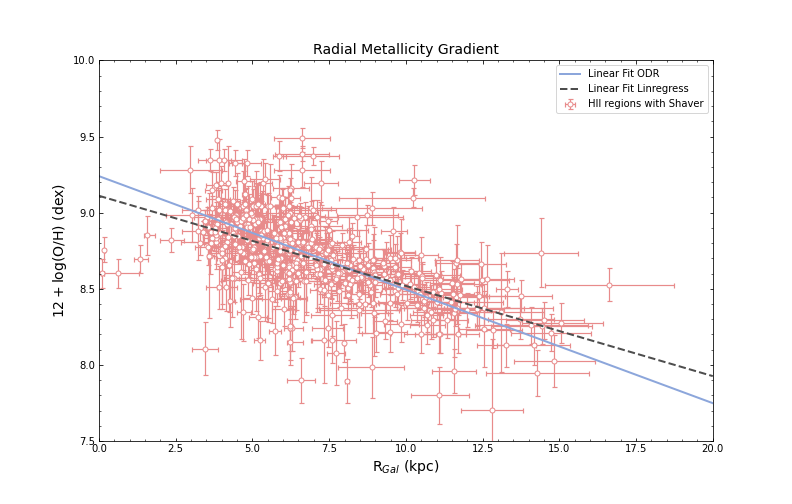

In [4]:
O_Shaver = O_abundance(Regions['Te'],Regions['e_Te'], Regions['R_Gal'], Regions['e_Rm'], Regions['e_Rp'])

The equation for the shaver gradient is:

$$ 12 + \log (O/H) =  ( -0.074571 \pm 0.004014)\text{R}_{Gal} + (9.239973 \pm 0.027332)$$

### Lineal model without temperature fluctions:

Choose model type: 'Shaver', 'Lineal without fluctuations', 'Lineal with fluctuations', 'Quadratic with fluctuations' Lineal without fluctuations
These are the results of our ODR Linear Fit:
Slope ODR: -0.049246 ± 0.002478
Intercept ODR: 8.891252 ± 0.016871 

These are the results of our Linear Fit using Linregress:
LinregressResult(slope=-0.03816523524646015, intercept=8.833175303310227, rvalue=-0.5822941280315723, pvalue=7.894922205138701e-44, stderr=0.0024683768981379906, intercept_stderr=0.018469173785149385)
Do you want to plot the data? (yes/no): yes


<IPython.core.display.Javascript object>


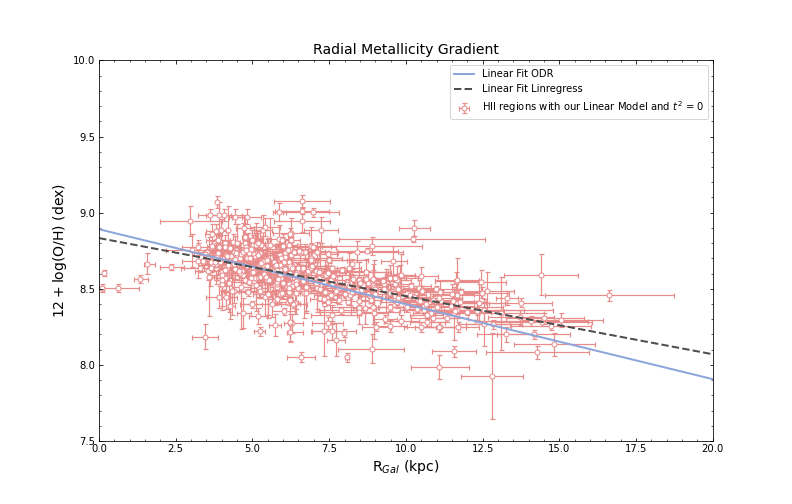

In [5]:
O_Lineal_t2eq0 = O_abundance(Regions['Te'],Regions['e_Te'], Regions['R_Gal'], Regions['e_Rm'], Regions['e_Rp'])

The equation for the case linear without temperature fluctions is:

$$ 12 + \log (O/H) =  (-0.049246 \pm 0.002478)\text{R}_{Gal} + (8.891252 \pm 0.016871)$$

### Lineal model with temperature fluctions:

Choose model type: 'Shaver', 'Lineal without fluctuations', 'Lineal with fluctuations', 'Quadratic with fluctuations' Lineal with fluctuations
These are the results of our ODR Linear Fit:
Slope ODR: -0.053946 ± 0.002984
Intercept ODR: 9.143793 ± 0.021134 

These are the results of our Linear Fit using Linregress:
LinregressResult(slope=-0.04571877138898871, intercept=9.082762082090376, rvalue=-0.5822941280315722, pvalue=7.894922205139039e-44, stderr=0.002956909825894468, intercept_stderr=0.022124531096793538)
Do you want to plot the data? (yes/no): yes


<IPython.core.display.Javascript object>


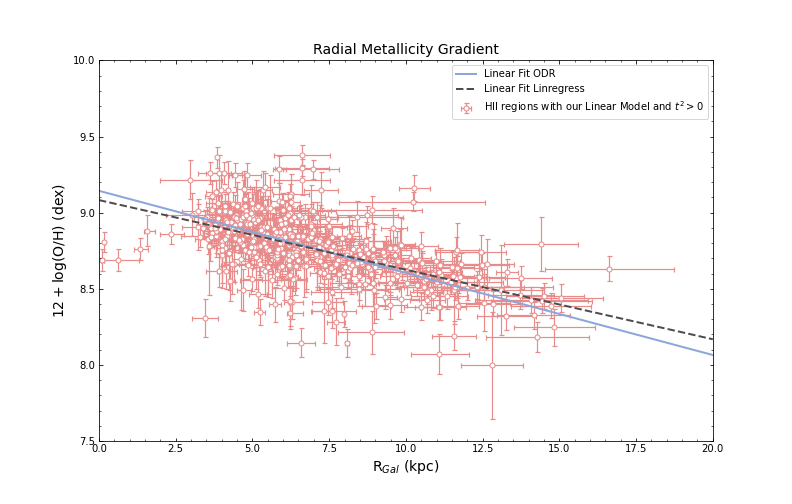

In [6]:
O_Lineal_t2geq0 = O_abundance(Regions['Te'],Regions['e_Te'], Regions['R_Gal'], Regions['e_Rm'], Regions['e_Rp'])

The equation for the case linear with temperature fluctions is:

$$ 12 + \log (O/H) =  (-0.053946 \pm 0.002984)\text{R}_{Gal} + (9.143793 \pm 0.021134 )$$

Conclusions:

- The results are consistent and show improved precision in the values. The error bars are smaller with our model compared to the Shaver model, indicating better accuracy.

- The findings suggest that when oxygen abundances are below approximately 8.8 dex, our model tends to increase the estimated abundance. Conversely, when abundances exceed around 9 dex, the model reduces the abundance values.

### Quadratic Model with temperature fluctions:

Choose model type: 'Shaver', 'Lineal without fluctuations', 'Lineal with fluctuations', 'Quadratic with fluctuations' Quadratic with fluctuations
What type error propagation want to use?: 'Traditional' or 'Montecarlo': Traditional
These are the results of our ODR Linear Fit:
Slope ODR: -0.042366 ± 0.002896
Intercept ODR: 9.083538 ± 0.020029 

These are the results of our Linear Fit using Linregress:
LinregressResult(slope=-0.04174715703272625, intercept=9.037095012540203, rvalue=-0.5851724723479866, pvalue=2.395736258388306e-44, stderr=0.002679921693828119, intercept_stderr=0.02005201860835778)
Do you want to plot the data? (yes/no): yes


<IPython.core.display.Javascript object>


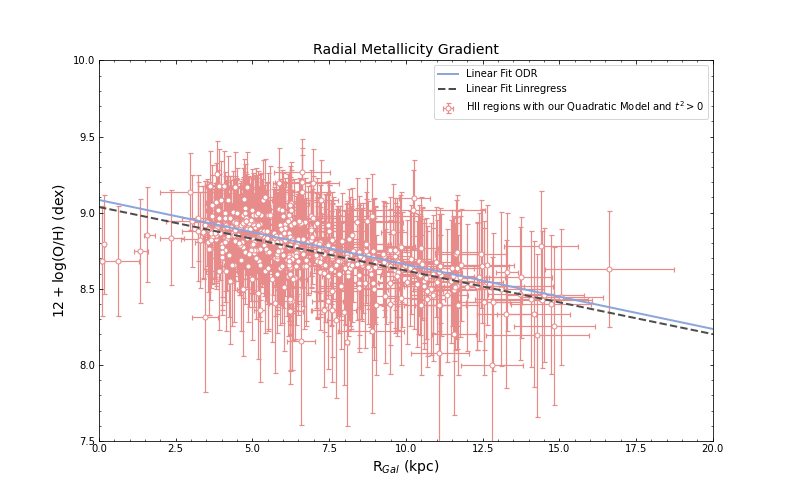

In [7]:
O_quadratic_t2geq0 = O_abundance(Regions['Te'],Regions['e_Te'], Regions['R_Gal'], Regions['e_Rm'], Regions['e_Rp'])

Choose model type: 'Shaver', 'Lineal without fluctuations', 'Lineal with fluctuations', 'Quadratic with fluctuations' Quadratic with fluctuations
What type error propagation want to use?: 'Traditional' or 'Montecarlo': Montecarlo
These are the results of our ODR Linear Fit:
Slope ODR: -0.043162 ± 0.002702
Intercept ODR: 9.046504 ± 0.020093 

These are the results of our Linear Fit using Linregress:
LinregressResult(slope=-0.04174715703272625, intercept=9.037095012540203, rvalue=-0.5851724723479866, pvalue=2.395736258388306e-44, stderr=0.002679921693828119, intercept_stderr=0.02005201860835778)


<IPython.core.display.Javascript object>


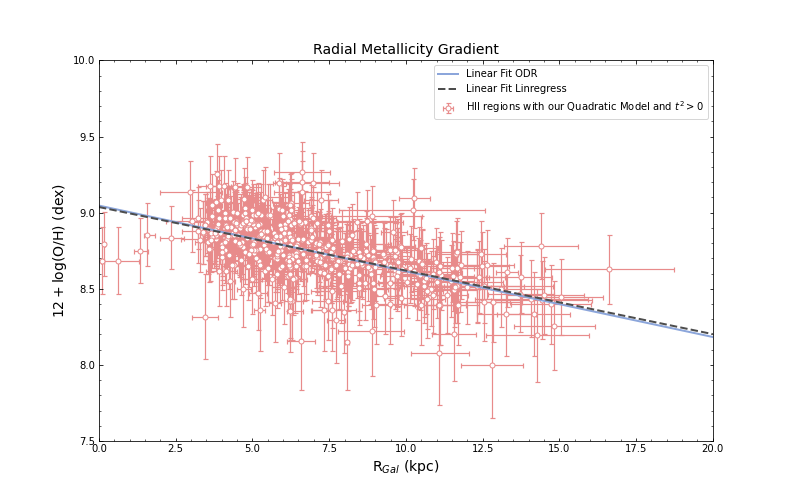

In [9]:
O_quadratic_t2geq0_2 = O_abundance(Regions['Te'],Regions['e_Te'], Regions['R_Gal'], Regions['e_Rm'], Regions['e_Rp'])

The equation for the case quadratic with temperature fluctions is:

$$ 12 + \log (O/H) =  (-0.042332 \pm 0.002894)\text{R}_{Gal} + (9.083696 \pm 0.020016)$$

Conclusions:
- Although the central values tend to increase for some data points and decrease or remain similar for others, applying traditional error propagation reveals that the resulting error bars are significantly larger compared to those from the Shaver calibrator. This indicates that, despite obtaining reasonable central values, the associated uncertainty is higher. Therefore, adopting this model may not be advisable.

- It would not be appropriate to use this adjustment.

In [10]:
print(len(O_Shaver))
print(len(O_Lineal_t2eq0))
print(len(O_Lineal_t2geq0))
print(len(O_quadratic_t2geq0))
print(len(O_quadratic_t2geq0_2))

468
468
468
468
468


## Stellar Metallicity Gradient:

In [11]:
#Update data:

#O stars:
StellarO = pd.read_csv('StellarO_parameters.csv')

#B stars:
StellarB = pd.read_csv('StellarB_parameters.csv')

# A comprehensive study of nearby early B-type stars and implications
table2 = "J/A+A/539/A143/Bstars" 
VIZIER_TAP_URL2 = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL2)

job2 = viz.launch_job_async(
    f"""SELECT TOP 20 Name, Teff, e_Teff, dists, e_dists, distH, e_distH, O, e_O
    FROM 
        "{table2}"
   """,
    output_format="csv",
)
tab2 = job2.get_results()
df2 = tab2.to_pandas()

#Cefeidas:
table3 = "J/AJ/156/171/table1" 
VIZIER_TAP_URL3 = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL3)

job3 = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table3}"
   """,
    output_format="csv",
)
tab3 = job3.get_results()
df3 = tab3.to_pandas()
df3 = df3[['Name','Plx', 'e_Plx', 'd','dmin','dmax', 'RG-Plx','_RA_icrs', '_DE_icrs']]
df3

table4 = "J/AJ/156/171/table7" 
VIZIER_TAP_URL4 = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL4)

job4 = viz.launch_job_async(
    f"""SELECT TOP 10000*
    FROM 
        "{table4}"
   """,
    output_format="csv",
)
tab4 = job4.get_results()
df4 = tab4.to_pandas()
df4 = df4[['Name', 'Oavg','[O/Fe]',  'R[O/Fe]', 'o_[O/Fe]']]
df4

merged_df = pd.merge(df3, df4, on='Name')

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [12]:
# We define functions that we will use:

# We define a function that returns RAC, DEC, l, and b:

def Stellar_Gradient(Name, Dist, e_Dist, E_Dist, O, e_Om, e_Op):
    
    """""
    Determines the chemical gradients of oxygen in the galaxy and performs a fit.
    Calculates the Galactocentric radii of the regions and their errors.
    Parameters:
    
        Name: Name of the stars in the sample that will be used to search in SIMBAD
        Dist: Heliocentric distance of the star (pc)
        e_Dist: Lower error in the Heliocentric distance of the star (pc)
        E_Dist: Upper error in the Heliocentric distance of the star (pc)
        O: Oxygen chemical abundance
        e_O: Error in the oxygen chemical abundance
    
    Returns: A pandas DataFrame with the following information:
    
        Name: Name of the stars in the sample that will be used to search in SIMBAD
        Dist: Heliocentric distance of the star
        e_Dist: Lower error in the Heliocentric distance of the star
        E_Dist: Upper error in the Heliocentric distance of the star
        O: Oxygen chemical abundance
        e_O: Error in the oxygen chemical abundance
        Rgal: Galactocentric radius (kpc)
        em_Rgal: Lower error in the Galactocentric radius (kpc)
        ep_Rgal: Maximum error in the Galactocentric radius (kpc)
        RAC: Right Ascension of the object (deg)
        DEC: Declination of the object (deg)
        l: Galactic longitude (deg)
        b: Galactic latitude (deg)
        
    """""
    
    def Coords(Name):
        
        """" 
        Determines the coordinates of the stars using Skycoord
        Parameters:
        
            Name: Name of the object
        
        Returns:
        
            RAC: Right Ascension of the object (deg)
            DEC: Declination of the object (deg)
            l: Galactic longitude (deg)
            b: Galactic latitude (deg)
            
        """
        # Empty lists
        l, b = [], []
        RAC, DEC = [], []

        ID = Name
        for name in ID:
            # Normal coordinates:
            coord_RAC = SkyCoord.from_name(name).ra.value
            coord_DEC = SkyCoord.from_name(name).dec.value
        
            ## Galactic coordinates:
            coord_l = SkyCoord.from_name(name).galactic.l.value
            coord_b = SkyCoord.from_name(name).galactic.b.value
            
            # We append them together
            RAC = np.append(RAC, coord_RAC)
            DEC = np.append(DEC, coord_DEC)
        
            l = np.append(l, coord_l)
            b = np.append(b, coord_b)
        
        return RAC, DEC, l, b
    
    coord = Coords(Name)
    
    RA, DE = coord[0], coord[1]
    l, b = coord[2], coord[3]

    # This function calculates all R, we provide the coordinates and the value of the Galactic Center
    
    def R(RA, DE, Dist, GC):
    
        Dist = Dist / 1000
        
        GC_median = np.median(GC)
        GC_16 = np.percentile(GC, 16)
        GC_84 = np.percentile(GC, 84)
    
        rd = SkyCoord(ra=(RA) * u.degree, dec=(DE) * u.degree, distance=(Dist) * u.kpc, frame='icrs') # Coordinates
        G_C_median = rd.transform_to(Galactocentric(galcen_distance=GC_median * u.kpc)) # Transformation
        G_C_16 = rd.transform_to(Galactocentric(galcen_distance=GC_16 * u.kpc))
        G_C_84 = rd.transform_to(Galactocentric(galcen_distance=GC_84 * u.kpc))
    
        R_C = np.sqrt((G_C_median.x / 3 + G_C_16.x / 3 + G_C_84.x / 3) ** 2 + (G_C_median.y / 3 + G_C_16.y / 3 + G_C_84.y / 3) ** 2 + \
            (G_C_median.z / 3 + G_C_16.z / 3 + G_C_84.z / 3) ** 2)
    
        return R_C
    
    Rgal = R(RA, DE, Dist, GC=8.2)
    
    Rgal = Rgal.value
    
    # We will create a function that evaluates errors in the Galactocentric distances using errors in the heliocentric distances 
    # (e_Dist), (E_Dist), and errors in the distance to the Galactic Center. It works if it has minus & plus errors

    def e_R(l, b, Dist, e_Dist, E_Dist):
    
        GC = 8.2  # Galactic Center
        e_GC = 0.1  # Error in the Galactic Center
        n_samples = 100000  # Number of Monte Carlo samples
        Dist = Dist / 1000
        
        if e_Dist is None and E_Dist is None:
            raise ValueError("At least one x error in the heliocentric distance must be provided.")
            
        elif e_Dist is None and E_Dist is not None:
            e_Distance = E_Dist / 1000
            
        elif E_Dist is None and e_Dist is not None:
            e_Distance = e_Dist / 1000
            
        else:
            e_Dist = e_Dist / 1000
            E_Dist = E_Dist / 1000
            
            e_Distance = (e_Dist + E_Dist) / 2
            
        # Empty lists:

        e_Rm_list2 = []  # Empty array that will store the minus error data
        e_Rp_list2 = []  # Empty array that will store the plus error data

        # We will create a series of Monte Carlo simulations for each row of our dataframe:
    
        for i in range(len(Dist)):         
    
            # Perform a Monte Carlo simulation of 100000 samples for each row of our dataframe
        
            # Monte Carlo simulation for heliocentric distance
            Dsun_samples = np.absolute(np.random.normal(Dist[i], e_Distance[i], n_samples))
            
            # Monte Carlo simulation for error in the distance to the Galactic center
            GC_samples = np.random.normal(GC, e_GC, n_samples) 
    
            # Call the function R to determine a Gaussian distribution of R
            RGC_samples = R(RA[i], DE[i], Dsun_samples * 1000, GC_samples).value 
            # Using Percentiles and Median:
        
            # Calculate the 16th and 84th percentiles
            R_16th = np.percentile(RGC_samples, 16)
            R_84th = np.percentile(RGC_samples, 84)
    
            # Asymmetric errors:
    
            R_m = np.median(RGC_samples)
            e_Rm = R_m - R_16th
            e_Rp = R_84th - R_m
    
            # Concatenate:
    
            e_Rm_list2 = np.append(e_Rm_list2, np.absolute(e_Rm))
            e_Rp_list2 = np.append(e_Rp_list2, np.absolute(e_Rp))
    
        return e_Rm_list2, e_Rp_list2
    
    e_Rgal = e_R(l, b, Dist, e_Dist, E_Dist)
    
    em_R, ep_R = e_Rgal[0], e_Rgal[1]
    
    # Models:
    x = np.linspace(0, 25, len(Rgal))
    ODR = linfit(Rgal, O, em_R, ep_R, e_Om, e_Op)
    
    print('These are the results of our ODR Linear Fit:')
    print(f"Slope ODR: {ODR[2]:.6f} ± {ODR[3]:.6f}")
    print(f"Intercept ODR: {ODR[0]:.6f} ± {ODR[1]:.6f} \n")

    linre1 = stats.linregress(Rgal, O)
    print('These are the results of our Linear Fit using Linregress:')
    print(f'Slope Linregress: {linre1[0]: .6f} ± {linre1[4]:.6f}')
    print(f'Intercept Linregress: {linre1[1]: .4f} ± {0.0319:.4f}')
    
    # Modern, professional color palette (consistent with previous suggestion)
    colors = {
        'O': '#5f85b0',        # pastel slate blue (soft dark blue)
        'B': '#6ed3cf',        # pastel cyan-teal
        'Cepheid': '#f3d885',  # pastel yellow (soft, warm, readable)
        'ODR': '#8ca6db',       # soft pastel blue
        'Linregress': '#4d4d4d' # charcoal gray
        }

    # Ask the user if they want to plot:
    response = input("Do you want to plot the data? (yes/no): ").strip().lower()

    if response == 'yes':
        # Ask the user what type of star they want to plot:
        type_star = input("What Star do you want to plot? O, B, Cepheids: ").strip().capitalize()

        # Plot settings
        fig, ax = plt.subplots(figsize=(10, 7))

        if type_star == 'O':
            label_data = 'O Stars (Weßmayer et al. 2022)'
            color_data = colors['O']
            file_out = 'StarsO_gradient'

        elif type_star == 'B':
            label_data = 'B Stars'
            color_data = colors['B']
            file_out = 'StarsB2_gradient'

        elif type_star == 'Cepheids':
            label_data = 'Cepheid Stars'
            color_data = colors['Cepheid']
            file_out = 'StarsCefeidas_gradient'

        else:
            print("Invalid star type. Please choose O, B, or Cepheids.")
            exit()

        # Plot data points
        ax.errorbar(Rgal, O, xerr=[em_R, ep_R], yerr=e_Om, fmt='o', markersize=5,
                    mfc='white', elinewidth=1.2, capsize=2.5, capthick=1.2,mec=color_data,
                    ecolor=color_data, lw=2, label=label_data, zorder=1)

        # ODR fit
        ax.plot(x, np.dot(np.vander(x, 2), [ODR[2], ODR[0]]), '-', color=colors['ODR'], lw=2,
                label='Linear Fit (ODR)', zorder=2)

        # Linregress fit
        ax.plot(x, np.dot(np.vander(x, 2), [linre1[0], linre1[1]]), '-.', color=colors['Linregress'], lw=2,
                label='Linear Fit (Linregress)', zorder=2)

        # Labels and title
        ax.set_ylabel('12 + $\log_{10}$(O/H) (dex)', fontsize=14)
        ax.set_xlabel('$R_{Gal}$ (kpc)', fontsize=14)

        # Legend and plot formatting
        ax.legend(loc='lower left', fontsize=10, frameon=False)
        ax.set_xlim(0, 24 if type_star == 'Cepheids' else 20)
        ax.set_ylim(7.5, 10)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
        ax.set_xticks(np.arange(0,21,2))
        ax.set_xlim(0,21)

        plt.tight_layout()
        plt.savefig(file_out, dpi=300)
        plt.show()

    elif response == 'no':
        print("Plotting skipped.")
    else:
        print("Invalid input. Please enter 'yes' or 'no'.")
        
    # We will create a df with the results:

    Data = {'Name': Name, 'RAC': RA, 'DEC': DE, 'l': l, 'b': b, 'd': Dist, 'em_d': e_Dist, 'ep_d': E_Dist,
            'O_abundance': O, 'em_O_abundance': e_Om, 'ep_O_abundance': e_Op, 'Rgal': Rgal, 'em_Rgal': em_R, 'ep_Rgal': ep_R}
    
    return pd.DataFrame(Data)

def parallax(p, e_p):
    
    # The function takes parallax (mas) and its errors in (mas) as input
    # It returns the heliocentric distance in pc
    
    mask = ~np.isnan(p) & ~np.isnan(e_p)
    
    p = p[mask]
    e_p = e_p[mask]
    
    # Parallax:
    
    D = np.absolute(1/p)*1000 # pc
    e_D = np.absolute(e_p/p**2)*1000 # pc
    
    return D, e_D


### O stars:

#### Quantitative spectroscopy of late O-type main-sequence stars with a hybrid non-LTE method

These are the results of our ODR Linear Fit:
Slope ODR: -0.103957 ± 0.038756
Intercept ODR: 9.553726 ± 0.342045 

These are the results of our Linear Fit using Linregress:
Slope Linregress: -0.073535 ± 0.036978
Intercept Linregress:  9.2881 ± 0.0319
Do you want to plot the data? (yes/no): yes
What Star do you want to plot? O, B, Cepheids: O


<IPython.core.display.Javascript object>


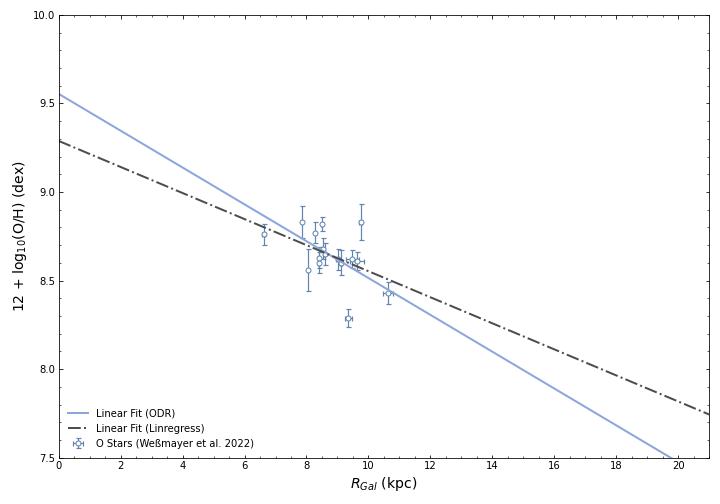

In [13]:
#Llamamos la función:
StarsO = Stellar_Gradient(StellarO['Name'], StellarO['dGaia'], StellarO['em_dGaia'],
                         StellarO['ep_dGaia'], StellarO['OII/III'],StellarO['e_OII/III'], None)

### Estrellas tipo B

#### Quantitative spectroscopy of B-type supergiants

These are the results of our ODR Linear Fit:
Slope ODR: -0.035892 ± 0.013523
Intercept ODR: 9.018255 ± 0.118084 

These are the results of our Linear Fit using Linregress:
Slope Linregress: -0.038990 ± 0.014349
Intercept Linregress:  9.0405 ± 0.0319
Do you want to plot the data? (yes/no): yes
What Star do you want to plot? O, B, Cepheids: B


<IPython.core.display.Javascript object>


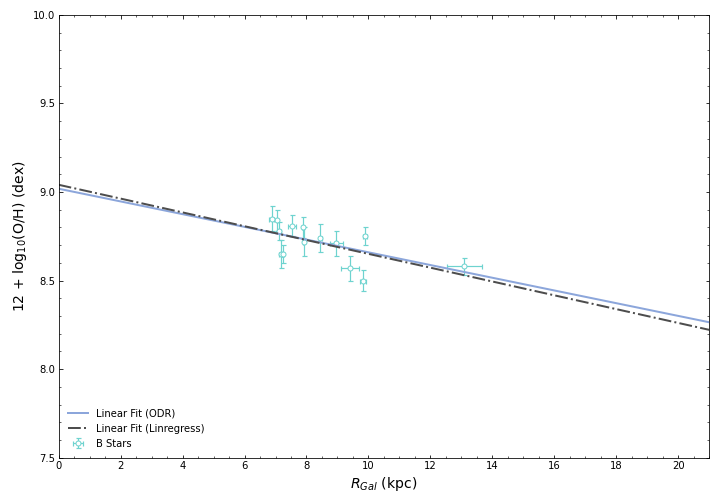

In [14]:
StarsB = Stellar_Gradient(StellarB['Object'], StellarB['dGaia'], StellarB['em_dGaia'], StellarB['ep_dGaia'], 
                          StellarB['O_abundances'], StellarB['e_Oabundances'], None)

#### A comprehensive study of nearby early B-type stars and implications for stellar and Galactic evolution and interstellar dust models

These are the results of our ODR Linear Fit:
Slope ODR: -0.037968 ± 0.072558
Intercept ODR: 9.075454 ± 0.603457 

These are the results of our Linear Fit using Linregress:
Slope Linregress: -0.055680 ± 0.079799
Intercept Linregress:  9.2223 ± 0.0319
Do you want to plot the data? (yes/no): yes
What Star do you want to plot? O, B, Cepheids: B


<IPython.core.display.Javascript object>


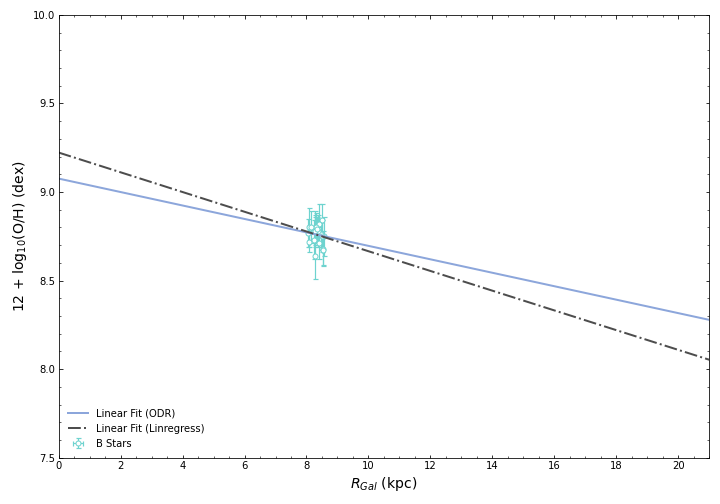

In [18]:
StarsB2 = Stellar_Gradient(df2['Name'], df2['dists'],None, df2['e_dists'], df2['O'], df2['e_O'], None)

### Estrellas Cefeidas

#### Cepheid Abundances:.Multiphase Results and Spatial Gradients

In [19]:
#Vamos a calcular las distancías de parallax Heliocentricas y sus errores:

distance_Cepheid = parallax(merged_df['Plx'], merged_df['e_Plx'])

merged_df['dplx'], merged_df['e_dplx'] = distance_Cepheid[0], distance_Cepheid[1]

In [20]:
outlier = ( ( (merged_df['d'] - merged_df['dmin']) < 2300 )  & ( (merged_df['dmax'] - merged_df['d']) < 2300) )

outlier2 = ( merged_df['e_dplx'] < 5000)

merged_df2 = merged_df[outlier]
merged_df2 = merged_df2[outlier2]

merged_df2 = merged_df2.reset_index(drop = True)
#merged_df = merged_df[outlier2]
#merged_df = merged_df.reset_index
#merged_df2.isna().sum()

<ipython-input-20-0484ecd2a5c4>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_df2 = merged_df2[outlier2]


In [21]:
merged_df2 = merged_df2.dropna(subset=['Oavg', '[O/Fe]']).reset_index(drop = True)
merged_df2 = merged_df2.reset_index(drop = True)

<IPython.core.display.Javascript object>


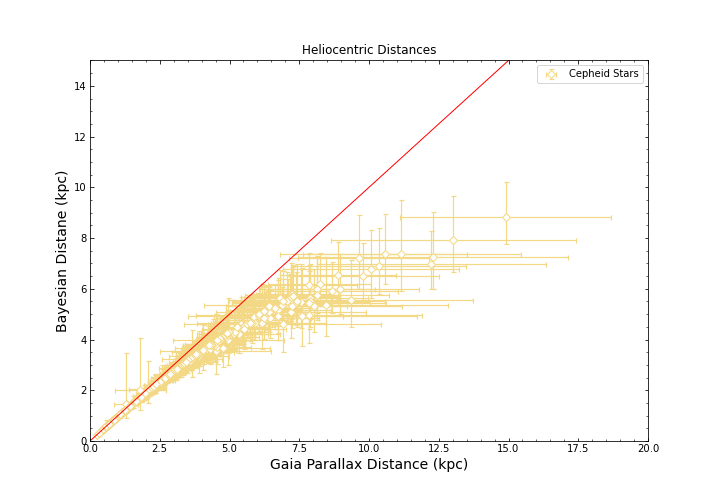

In [22]:
#Vamos a graficar los resultados:
fig, ax = plt.subplots(figsize=(10,7))

#Comparando distancias heliocentricas:
x = np.arange(0,21,1)
ax.plot(x,x, c = 'r', zorder = 1, lw = 1)
ax.errorbar(merged_df2['dplx']/1000, merged_df2['d']/1000, xerr = merged_df2['e_dplx']/1000,
            yerr =  [(merged_df2['d'] - merged_df2['dmin'])/1000,(merged_df2['dmax'] - merged_df2['d'])/1000], lw = 1,
            fmt = 'D', mfc='white', mec= '#f3d885', capsize=2.5, capthick = 1.2, ecolor = '#f3d885',elinewidth = 1.2, 
            alpha = 1,label = 'Cepheid Stars', zorder = 0)
ax.set_title('Heliocentric Distances')
ax.set_ylabel('Bayesian Distane (kpc)', size = 14)
ax.set_xlabel('Gaia Parallax Distance (kpc)', size = 14)
ax.legend(loc = 'best')
ax.grid(False)
# Axis ticks and limits
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax.set_xlim(0,20)
ax.set_ylim(0,15)

plt.savefig('Distancias_Cefeidas', dpi = 300)

In [23]:
merged_df2 = merged_df2[~merged_df2['Name'].isin(['CE Cas A', 'CE Cas B'])]
merged_df2 = merged_df2.reset_index(drop = True)
merged_df2

,Name,Plx,e_Plx,d,dmin,dmax,RG-Plx,_RA_icrs,_DE_icrs,Oavg,[O/Fe],R[O/Fe],o_[O/Fe],dplx,e_dplx
0,X Sgr,3.4314,0.2020,291,274,310,7.609,266.8901,-27.8308,8.702,0.302,0.572,12,291.426240,17.155709
1,AV Sgr,0.5510,0.0689,1748,1550,2002,6.106,271.2033,-22.7324,8.820,-0.321,NaN,1,1814.882033,226.942599
2,AP Sgr,1.1190,0.0527,874,835,916,7.017,273.2604,-23.1173,8.820,0.010,NaN,1,893.655049,42.087240
3,VY Sgr,0.3895,0.0739,2424,2027,3004,5.392,273.0190,-20.7041,8.907,-0.076,NaN,1,2567.394095,487.112769
4,WZ Sgr,0.5131,0.0773,1875,1623,2217,6.009,274.2488,-19.0758,8.800,-0.162,0.310,1,1948.937829,293.613124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,RV Sco,1.1306,0.0552,866,825,910,7.034,254.5823,-33.6091,8.696,-0.067,0.078,2,884.486114,43.183826
400,V0482 Sco,0.9204,0.0470,1057,1006,1114,6.820,262.7015,-33.6099,8.774,-0.016,NaN,1,1086.484137,55.481046
401,RY Sco,0.7975,0.1003,1237,1093,1425,6.651,267.7181,-33.7057,8.766,0.009,NaN,1,1253.918495,157.702853
402,BF Oph,1.1764,0.0630,833,791,881,7.061,256.5229,-26.5806,8.737,0.019,0.008,2,850.051003,45.522963


These are the results of our ODR Linear Fit:
Slope ODR: -0.066341 ± 0.002561
Intercept ODR: 9.277104 ± 0.021040 

These are the results of our Linear Fit using Linregress:
Slope Linregress: -0.031244 ± 0.001991
Intercept Linregress:  8.9901 ± 0.0319
Do you want to plot the data? (yes/no): yes
What Star do you want to plot? O, B, Cepheids: Cepheids


<IPython.core.display.Javascript object>


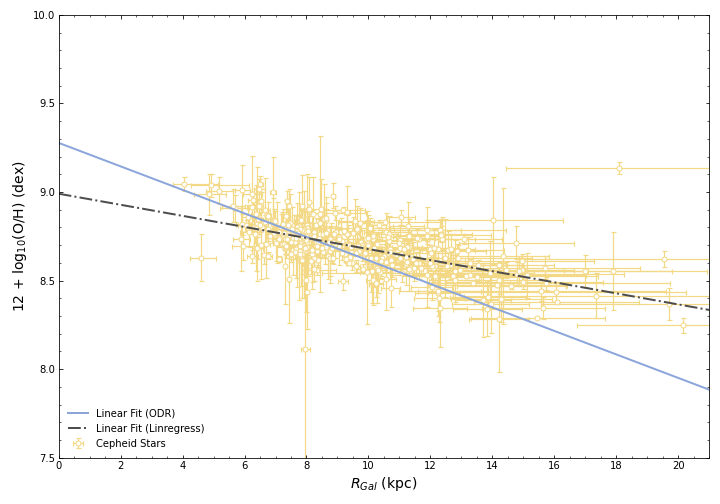

In [24]:
Cefeidas = Stellar_Gradient(merged_df2['Name'], merged_df2['dplx'], merged_df2['e_dplx'], None, 
                            merged_df2['Oavg'], merged_df2['[O/Fe]'], None) #For a while we're use merged_df2['o_[O/Fe]']

These are the results of our ODR Linear Fit:
Slope ODR: -0.055770 ± 0.001539
Intercept ODR: 9.194054 ± 0.015479 

These are the results of our Linear Fit using Linregress:
Slope Linregress: -0.042726 ± 0.002562
Intercept Linregress:  9.0830 ± 0.0319
Do you want to plot the data? (yes/no): yes
What Star do you want to plot? O, B, Cepheids: Cepheids


<IPython.core.display.Javascript object>


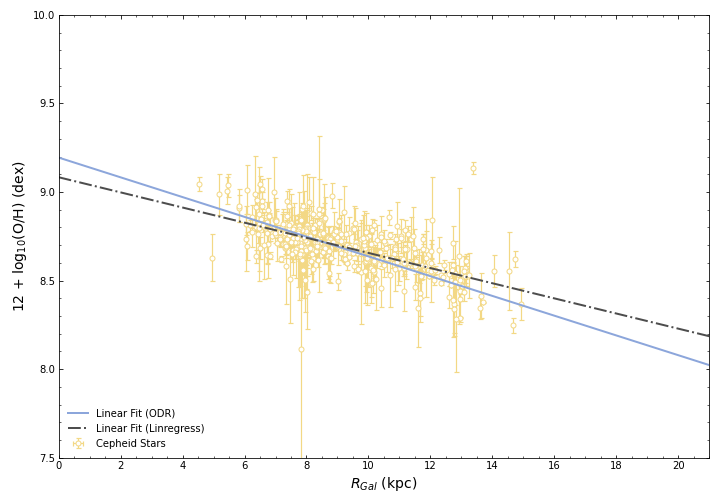

In [25]:
Cefeidas2 = Stellar_Gradient(merged_df2['Name'], merged_df2['d'], (merged_df2['d'] - merged_df2['dmin'])/1000,
                             (merged_df2['dmax'] - merged_df2['d'])/1000, merged_df2['Oavg'], merged_df2['[O/Fe]'], None)

In [33]:
outlier  = ( (Cefeidas['em_Rgal'] < 1.2) & (Cefeidas['ep_Rgal'] < 1.2) )
Cefeidas2 = Cefeidas2[outlier]
Cefeidas2 = Cefeidas2.reset_index(drop = True)
max(Cefeidas2['Rgal'])

14.212763667098166

<IPython.core.display.Javascript object>


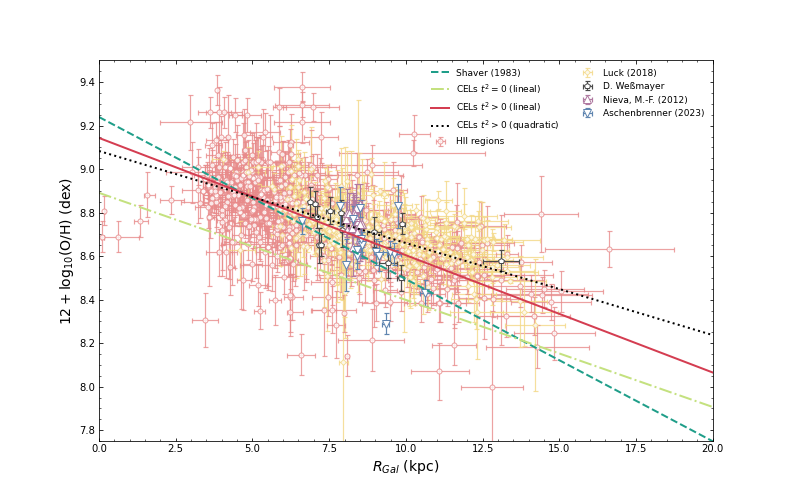

In [35]:
fig, ax = plt.subplots(figsize=(11, 7))

x = np.linspace(0, 27, 1000)

# Lines (adjustments)
y1 = -0.074571 * x + 9.239973  # Shaver
y2 = -0.049246 * x + 8.891252  # t^2 = 0
y3 = -0.053946 * x + 9.143793  # t^2 > 0
y4 = -0.042332 * x + 9.083696 #t^2 > 0 quadratic
# Modern professional color palette
colors = {
    'shaver': '#1f9e89',        # vivid teal-green (bright, crisp)
    't2_0': '#c4e17f',          
    't2_gt0': '#d43d51',        # clear strong red (rich crimson, not too dark)
    'HII': '#e88b8b',           
    'Luck': '#f3d885',          
    'D. Weßmayer': '#4a4a4a',    
    'Nieva': '#B07AA1',         
    'Aschen': '#5f85b0',        
}

# Plot data points
ax.errorbar(O_Lineal_t2geq0['Rgal'], O_Lineal_t2geq0['O_abundance'],
            xerr=[O_Lineal_t2geq0['e_Rgal'], O_Lineal_t2geq0['E_Rgal']],
            yerr=O_Lineal_t2geq0['e_O_abundance'], fmt='o', markersize=5,elinewidth=1.2,
            capsize=2.5, capthick=1.2, mfc='white', mec=colors['HII'],
            ecolor=colors['HII'],lw=2,  label='HII regions', zorder=0, alpha = 0.8)
    
#ax.errorbar(O_quadratic_t2geq0_2['Rgal'], O_quadratic_t2geq0_2['O_abundance'],
 #          xerr = [O_quadratic_t2geq0_2['e_Rgal'], O_quadratic_t2geq0_2['E_Rgal']],
  #         yerr = [O_quadratic_t2geq0_2['e_Om'], O_quadratic_t2geq0_2['e_Op']], fmt = 'o',
   #        markersize = 5, elinewidth = 1.2,capsize = 2.5, capthick = 1.2, mfc = 'white', mec = colors['HII'],
    #       ecolor = colors['HII'], lw = 2, label = 'HII regions', zorder = 0, alpha = 0.8)

ax.errorbar(Cefeidas2['Rgal'], Cefeidas2['O_abundance'],
            xerr=[Cefeidas2['em_Rgal'], Cefeidas2['ep_Rgal']],
            yerr= Cefeidas2['em_O_abundance'], fmt='D', markersize=4,elinewidth=1.2,
            capsize=2.5, capthick=1.2, mfc='white', mec=colors['Luck'], ecolor=colors['Luck'],
            lw=2, label='Luck (2018)', zorder=0, alpha =0.8)

ax.errorbar(StarsB['Rgal'], StarsB['O_abundance'],
            xerr=[StarsB['em_Rgal'], StarsB['ep_Rgal']],
            yerr=StarsB['em_O_abundance'], fmt='p', markersize=5.5,elinewidth=1.2,
            capsize=2.5, capthick=1.2,mfc='white', mec=colors['D. Weßmayer'], ecolor=colors['D. Weßmayer'],
            lw=2, label='D. Weßmayer', zorder=1)

ax.errorbar(StarsB2['Rgal'], StarsB2['O_abundance'],
            xerr=[StarsB2['em_Rgal'], StarsB2['ep_Rgal']],
            yerr=StarsB2['em_O_abundance'], fmt='^', markersize=7.3, elinewidth=1.2,
            capsize=2.5, capthick=1.2, mfc='white', mec=colors['Nieva'], ecolor=colors['Nieva'],
            lw=2, label='Nieva, M.-F. (2012)', zorder=1)

ax.errorbar(StarsO['Rgal'], StarsO['O_abundance'],
            xerr=[StarsO['em_Rgal'], StarsO['ep_Rgal']],
            yerr=StarsO['em_O_abundance'], fmt='v', markersize=7.3, elinewidth=1.2,
            capsize=2.5, capthick=1.2, mfc='white', mec=colors['Aschen'], ecolor=colors['Aschen'],
            lw=2, label='Aschenbrenner (2023)', zorder=1)

# Plot lines
ax.plot(x, y1, '--', color=colors['shaver'], lw=2, label='Shaver (1983)', zorder=2)
ax.plot(x, y2, '-.', color=colors['t2_0'], lw=2, label='CELs $t^2=0$ (lineal)', zorder=2)
ax.plot(x, y3, '-', color=colors['t2_gt0'], lw=2, label='CELs $t^2>0$ (lineal)', zorder=2)
ax.plot(x, y4, ':', color='k', lw=2, label='CELs $t^2>0$ (quadratic)', zorder=2)

# Axis labels and title
#ax.set_title('Radial Metallicity Gradient', fontsize=16)
ax.set_xlabel('$R_{Gal}$ (kpc)', fontsize=14)
ax.set_ylabel('$12 + \\log_{10}$(O/H) (dex)', fontsize=14)

# Legend clean-up
ax.legend(loc='upper right', fontsize=9, frameon=False, ncol = 2)

# Axis ticks and limits
ax.set_xlim(0, 20)
ax.set_ylim(7.75, 9.5)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

plt.savefig('Resultado_Prelinimar', dpi = 300)

In [36]:
#Save Dataframe
Cefeidas2['Name'].to_csv("Cefaidas_names.txt",index=False)

## Comments

- As we can see the best model that describe the abundances of the HII and Stars abundances is the quadratic temperature-metallicity relationship from CEL and considering the tempeture fluctuations, but, there is a problem. The uncertainties in the abundances are so large. So our work is to solve it!

In [ ]:
#If we want to use the EDR3 Gaia
from astroquery.gaia import Gaia
from astropy.table import vstack

# Create an empty list to collect result tables
results_list = []

# Loop over all indices (or a subset for testing first)
for i in range(len(Cefeidas2['Name'])):
    try:
        coord = SkyCoord(ra=Cefeidas2['RAC'][i], dec=Cefeidas2['DEC'][i], unit=(u.degree, u.degree), frame='icrs')
        j = Gaia.cone_search_async(coord, radius=u.Quantity(1000*u.mas))
        r = j.get_results()
        
        # Optional: Add the index as a new column to track origin
        r['cefeida_index'] = i

        results_list.append(r)
    except Exception as e:
        print(f"Error at index {i}: {e}")

# Combine all the individual tables into one
if results_list:
    combined_results = vstack(results_list)
else:
    combined_results = None

combined_results

In [ ]:
len(combined_results)

In [ ]:
distance = parallax(combined_results['parallax'], combined_results['parallax_error'])

In [ ]:
#Vamos a graficar los resultados:
fig, ax = plt.subplots(figsize=(10,7))

#Comparando distancias heliocentricas:
x = np.arange(0,21,1)
ax.plot(x,x, c = 'r', zorder = 1, lw = 1)
ax.errorbar(Cefeidas['d']/1000, distance[0]/1000, xerr = Cefeidas['em_d']/1000,
            yerr = distance[1]/1000, lw = 1,
            fmt = 'D', mfc='white', mec= '#f3d885', capsize=2.5, capthick = 1.2, ecolor = '#f3d885',elinewidth = 1.2, 
            alpha = 1,label = 'Cepheid Stars', zorder = 0)
#ax.set_title('Heliocentric Distances')
ax.set_ylabel('Gaia Parallax Distance (kpc) EDR3', size = 14)
ax.set_xlabel('Gaia Parallax Distance (kpc) DR2', size = 14)
ax.legend(loc = 'best')
ax.grid(False)
# Axis ticks and limits
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax.set_xlim(0,15)
ax.set_ylim(0,15)

#plt.savefig('Distancias_Cefeidas', dpi = 300)